In [94]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from fa2 import ForceAtlas2
from scipy.spatial.distance import squareform
import joblib
import matplotlib
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15
# import custom functions
from maximumentropymodels import *

  0%|          | 49/10000 [00:00<00:20, 485.92it/s]

testing standard configuration model
500 nodes, barabasi-albert


  1%|▏         | 125/10000 [00:00<00:21, 455.10it/s]


Loops  126
Error margin:  [9.65103682e-06]


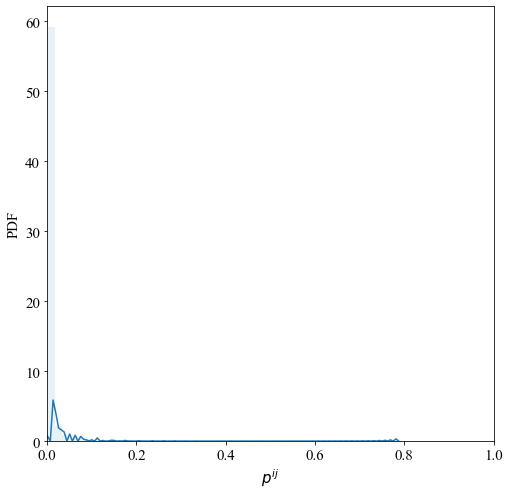

In [95]:
%run maximumentropymodels

# Import Network Data

In [96]:
(Gfattail, Gpoisson, network_datafattail, network_datapois)=joblib.load("networkdata.pkl")

In [97]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [99]:
Gfattail_pos=nx.from_pandas_edgelist(network_datafattail[network_datafattail['binary_label']==1], "node_1", "node_2")
Gpoisson_pos=nx.from_pandas_edgelist(network_datapois[network_datapois['binary_label']==1], "node_1", "node_2")


Gfattail_neg=nx.from_pandas_edgelist(network_datafattail[network_datafattail['binary_label']==0], "node_1", "node_2")
Gpoisson_neg=nx.from_pandas_edgelist(network_datapois[network_datapois['binary_label']==0], "node_1", "node_2")

positionsfattail = forceatlas2.forceatlas2_networkx_layout(Gfattail_pos, pos=None, iterations=2000)
positionspoisson = forceatlas2.forceatlas2_networkx_layout(Gpoisson_pos, pos=None, iterations=2000);

  1%|          | 11/2000 [00:00<00:18, 106.72it/s]

BarnesHut Approximation  took  5.98  seconds
Repulsion forces  took  15.63  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


100%|██████████| 2000/2000 [00:29<00:00, 68.07it/s]


BarnesHut Approximation  took  9.12  seconds
Repulsion forces  took  18.85  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.49  seconds


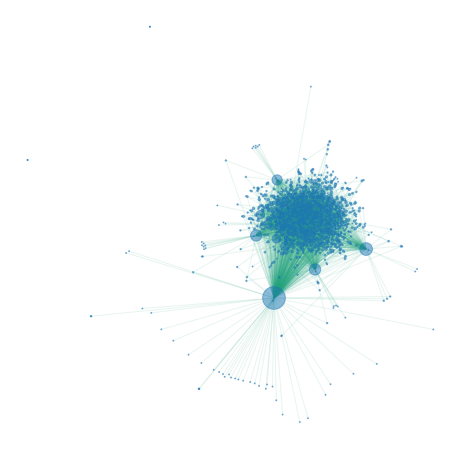

In [100]:
plt.figure(figsize = (8, 8))
nx.draw_networkx_nodes(Gfattail_pos, positionsfattail , node_size=[Gfattail_pos.degree(k) for k in Gfattail_pos.nodes], alpha=0.5)
nx.draw_networkx_edges(Gfattail_pos, positionsfattail , edge_color=np.array([27,158,119])/255, alpha=0.1)
plt.axis('off');

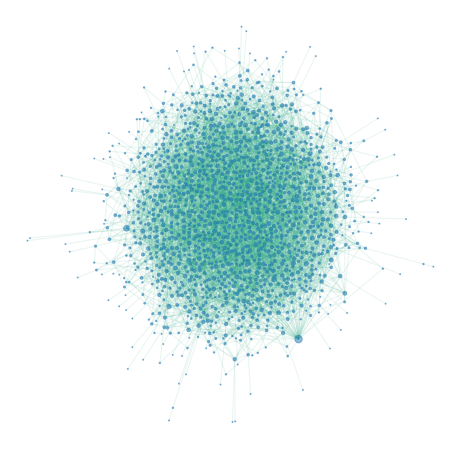

In [101]:
plt.figure(figsize = (8, 8))
nx.draw_networkx_nodes(Gpoisson_pos, positionspoisson, node_size=[Gpoisson_pos.degree(k) for k in Gpoisson_pos.nodes], alpha=0.5)
nx.draw_networkx_edges(Gpoisson_pos, positionspoisson , edge_color=np.array([27,158,119])/255, alpha=0.1)
plt.axis('off');

# Fat-Tail

In [122]:
kvecfattail_01=np.array([[Gfattail_neg.degree(k) if k in Gfattail_neg.nodes else 0 for k in Gfattail.nodes]]).T
kvecfattail_10=np.array([[Gfattail_pos.degree(k) if k in Gfattail_pos.nodes else 0 for k in Gfattail.nodes]]).T

In [124]:
# configuration model standard
(pconfstandard, kcal_confstandard)=configuration_model(kvecfattail_10)

  0%|          | 46/10000 [00:01<04:38, 35.77it/s]

Loops  47
Error margin:  [8.794493e-06]


In [125]:
# configuration with positive and negative links
(pconf01, k01cal, pconf10, k10cal, pconditional)=multidegree_entropy_pos_neg(kvecfattail_01, kvecfattail_10)

  0%|          | 38/10000 [00:02<12:47, 12.98it/s]

Loops  39
Error margin:  [9.78445063e-06]


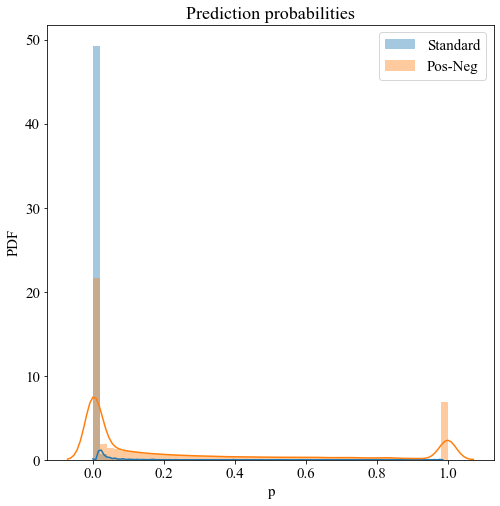

In [129]:
f, ax=plt.subplots(figsize = (8, 8))
msel=squareform(pconfstandard)
sns.distplot(msel,label='Standard', ax=ax)

msel=squareform(pconditional)
ecdf=ECDF(msel)
sns.distplot(msel,label='Pos-Neg', ax=ax)

plt.legend()
plt.xlabel('p')
plt.ylabel('PDF');
plt.title('Prediction probabilities');

# Poisson

In [130]:
kvecpoisson_01=np.array([[Gpoisson_neg.degree(k) if k in Gpoisson_neg.nodes else 0 for k in Gpoisson.nodes]]).T
kvecpoisson_10=np.array([[Gpoisson_pos.degree(k) if k in Gpoisson_pos.nodes else 0 for k in Gpoisson.nodes]]).T

In [131]:
# configuration model standard
(pconfstandard, kcal_confstandard)=configuration_model(kvecpoisson_10)

  7%|▋         | 733/10000 [00:13<02:45, 55.95it/s]

Loops  734
Error margin:  [9.89203964e-06]


In [132]:
# configuration with positive and negative links
(pconf01, k01cal, pconf10, k10cal, pconditional)=multidegree_entropy_pos_neg(kvecpoisson_01, kvecpoisson_10)

  5%|▍         | 455/10000 [00:24<08:34, 18.56it/s]

Loops  456
Error margin:  [9.79424909e-06]


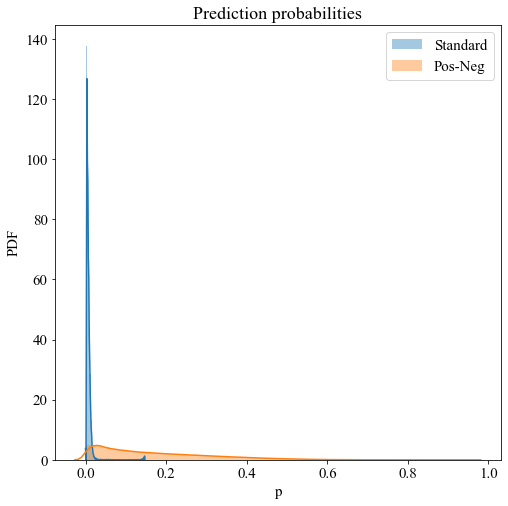

In [133]:
f, ax=plt.subplots(figsize = (8, 8))
msel=squareform(pconfstandard)
sns.distplot(msel,label='Standard', ax=ax)

msel=squareform(pconditional)
ecdf=ECDF(msel)
sns.distplot(msel,label='Pos-Neg', ax=ax)

plt.legend()
plt.xlabel('p')
plt.ylabel('PDF');
plt.title('Prediction probabilities');